Name: Ying Wang

Github Username: Notrew

USC ID: 9965632493

In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
import os 
import re
import pandas as pd
from scipy import stats
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import statsmodels.api as sm
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings("ignore")

### 1.a download data and pre-processing
    1.remove the last comma in line 485 of dataset9 and dataset14 in cycling folder
    2.remember dataset8 in sitting folder only has 479 valid rows
    3.split dataset4 in bending4 by whitespace

### 1.b 
Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.
    

In [2]:
#read files and name like bending1_1
folders = ["bending1","bending2","cycling","lying","sitting","standing","walking"]
dfs = {}
for i in folders:
    url = "../data/AReM/"+i+"/"
    file = os.listdir(url)
    for f in file:
        dataset_num = re.findall(r"\d+",f)[0]
        df_class = re.findall(r"\D+",i)[0]
        df_name = i+"_"+dataset_num
        real_url = url+f
        locals()[df_name] = pd.read_csv(real_url,skiprows=4)
        locals()[df_name]["dataset"] = df_name
        locals()[df_name]["class"] = df_class #df_class: bending, i: bending1
        dfs[df_name] = locals()[df_name]

In [3]:
dfs_keys = sorted(list(dfs.keys()))
testsets = ["bending1_1","bending1_2","bending2_1","bending2_2","cycling_1","cycling_2","cycling_3",
            "lying_1","lying_2","lying_3","sitting_1","sitting_2","sitting_3",
            "standing_1","standing_2","standing_3","walking_1","walking_2","walking_3"]
trainsets = sorted(list(set(dfs_keys)-set(testsets)))

df_test = locals()[testsets[0]]
for i in testsets[1:]:
    df_test = pd.concat([df_test,locals()[i]])
    
df_train = locals()[trainsets[0]]
for i in trainsets[1:]:
    df_train = pd.concat([df_train,locals()[i]])
    
df_test = df_test.reset_index().drop(["index"],axis=1)    
df_train = df_train.reset_index().drop(["index"],axis=1)

df_test
df_train

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,dataset,class
0,0,42.00,0.71,21.25,0.43,30.00,0.00,bending1_3,bending
1,250,41.50,0.50,20.25,1.48,31.25,1.09,bending1_3,bending
2,500,41.50,0.50,14.25,1.92,33.00,0.00,bending1_3,bending
3,750,40.75,0.83,15.75,0.43,33.00,0.00,bending1_3,bending
4,1000,40.00,0.71,20.00,2.74,32.75,0.43,bending1_3,bending
...,...,...,...,...,...,...,...,...,...
33114,118750,31.50,1.66,12.50,3.20,14.25,4.44,walking_9,walking
33115,119000,27.33,1.25,11.33,0.94,20.00,4.00,walking_9,walking
33116,119250,37.80,7.68,14.20,2.48,17.25,0.83,walking_9,walking
33117,119500,33.75,1.30,15.75,5.21,16.50,2.69,walking_9,walking


### 1.c Feature Extraction(focus on time-domain features)
    

### 1.c.i. 
Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc)

    mean,standard deviations,maximum and minimum values, and sometimes skewness and kurtosi

### 1.c.ii. 
Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance.You are free to normalize/standardize features or use them directly.
Your new dataset will look like this:

|Instance|$min_{1}$| $max_{1}$ |$mean_{1}$|$median_{1}$|...|$1st$ $quart_{6}$|$3rd$ $quart_{6}$|
|---|---|---|---|---|---|---|---|
|1| |   | |  |  |  |  |  |
|2| |   | |  |  |  |  |  |
|...| |   | |  |  |  |  |  |
|88| |   | |  |  |  |  |  |

where, for example, $1st$ $quart_{6}$, means the first quartile of the sixth time series in each of the 88 instances.

In [4]:
col_rename = ["min_1","max_1","mean_1","median_1","std_1","Q1_1","Q3_1","min_2","max_2","mean_2","median_2","std_2","Q1_2","Q3_2",
             "min_3","max_3","mean_3","median_3","std_3","Q1_3","Q3_3","min_4","max_4","mean_4","median_4","std_4","Q1_4","Q3_4",
             "min_5","max_5","mean_5","median_5","std_5","Q1_5","Q3_5","min_6","max_6","mean_6","median_6","std_6","Q1_6","Q3_6"]

def row_of_42features(df):
    dataset = df.iloc[0]["dataset"]
    df_des = df.describe().T.tail(-1)
    target_cols = df_des.columns[[3,7,1,5,2,4,6]]
    df_des = df_des[target_cols]
    res = df_des.iloc[[0]].reset_index().loc[:,"min":]
    for row in range(1,6):
        row_name = "row"+str(row)
        tmp = df_des.iloc[[row]].reset_index().loc[:,"min":]
        res = pd.concat([res,tmp],axis=1)
    res.columns = col_rename
    res["dataset"] = dataset
    return res

In [5]:
for df in dfs_keys:
    tmp = row_of_42features(locals()[df])
    if df == "bending1_1":
        features = tmp
    else:
        features = pd.concat([features,tmp])
features = features.reset_index().drop(["index"],axis=1)
features

,min_1,max_1,mean_1,median_1,std_1,Q1_1,Q3_1,min_2,max_2,mean_2,...,Q1_5,Q3_5,min_6,max_6,mean_6,median_6,std_6,Q1_6,Q3_6,dataset
0,37.25,45.00,40.624792,40.500,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,33.0000,36.00,0.0,1.92,0.570583,0.430,0.582915,0.00,1.3000,bending1_1
1,38.00,45.67,42.812812,42.500,1.435550,42.00,43.6700,0.0,1.22,0.372437,...,32.0000,34.50,0.0,3.11,0.571083,0.430,0.601010,0.00,1.3000,bending1_2
2,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.430,0.513506,0.00,0.9400,bending1_3
3,33.00,47.75,42.179812,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.500,0.524317,0.00,1.0000,bending1_4
4,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.430,0.389164,0.00,0.5000,bending1_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,4.223792,...,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050,walking_5
84,21.50,51.00,34.935812,35.500,4.645944,32.00,38.0625,0.0,12.21,4.115750,...,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000,walking_6
85,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,4.396958,...,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200,walking_7
86,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,4.398833,...,14.0000,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600,walking_8


### 1.c.iii
Estimate the standard deviation of each of the time-domain features you extracted from the data. 

Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [6]:
#estimate the standard deviation
f_std = pd.DataFrame(np.std(features,ddof=1))
f_std.columns = ["est_std"]
f_std

,est_std
min_1,9.569975
max_1,4.394362
mean_1,5.335718
median_1,5.440054
std_1,1.772153
Q1_1,6.153590
Q3_1,5.138925
min_2,0.000000
max_2,5.062729
mean_2,1.574164


In [7]:
#calculate 90% bootsrap confidence interval
low = []
high = []
for col in col_rename:
    data = np.array(features[col])
    data = (data,)
    res = stats.bootstrap(data,np.std,confidence_level=0.9,method="basic",random_state=2009)
    ci = res.confidence_interval
    low.append(ci.low)
    high.append(ci.high)    
ci_df = pd.DataFrame({"ci-low":low,"ci-high":high},index=col_rename) #"features":col_rename,
std_ci_df = pd.concat([f_std,ci_df],axis=1)
std_ci_df

,est_std,ci-low,ci-high
min_1,9.569975,8.315437,10.801130
max_1,4.394362,3.483271,5.436169
mean_1,5.335718,4.763651,5.926638
median_1,5.440054,4.851077,6.056791
std_1,1.772153,1.584012,1.961037
Q1_1,6.153590,5.632870,6.691523
Q3_1,5.138925,4.407889,5.927691
min_2,0.000000,0.000000,0.000000
max_2,5.062729,4.701221,5.471553
mean_2,1.574164,1.434522,1.740545


### 1.c.iv. 
Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

In [8]:
f_mean = pd.DataFrame(np.mean(features)).T
f_mean.index = ["mean"]
f_max = pd.DataFrame(np.max(features)).T.drop(["dataset"],axis=1)    
f_max.index = ["max"]
f_min = pd.DataFrame(np.min(features)).T.drop(["dataset"],axis=1)    
f_min.index = ["min"]
f_range = pd.concat([f_min,f_max]).diff()[1:]
f_range.index = ["range"]
f_des = pd.concat([f_mean.T,f_range.T,std_ci_df],axis=1)
f_des

,mean,range,est_std,ci-low,ci-high
min_1,29.036705,48.0,9.569975,8.315437,10.801130
max_1,45.473068,26.25,4.394362,3.483271,5.436169
mean_1,38.917357,23.441208,5.335718,4.763651,5.926638
median_1,38.856705,23.75,5.440054,4.851077,6.056791
std_1,2.988893,7.652108,1.772153,1.584012,1.961037
Q1_1,37.019830,24.8125,6.153590,5.632870,6.691523
Q3_1,41.197216,27.5,5.138925,4.407889,5.927691
min_2,0.000000,0.0,0.000000,0.000000,0.000000
max_2,6.290114,16.81,5.062729,4.701221,5.471553
mean_2,1.459119,4.569396,1.574164,1.434522,1.740545


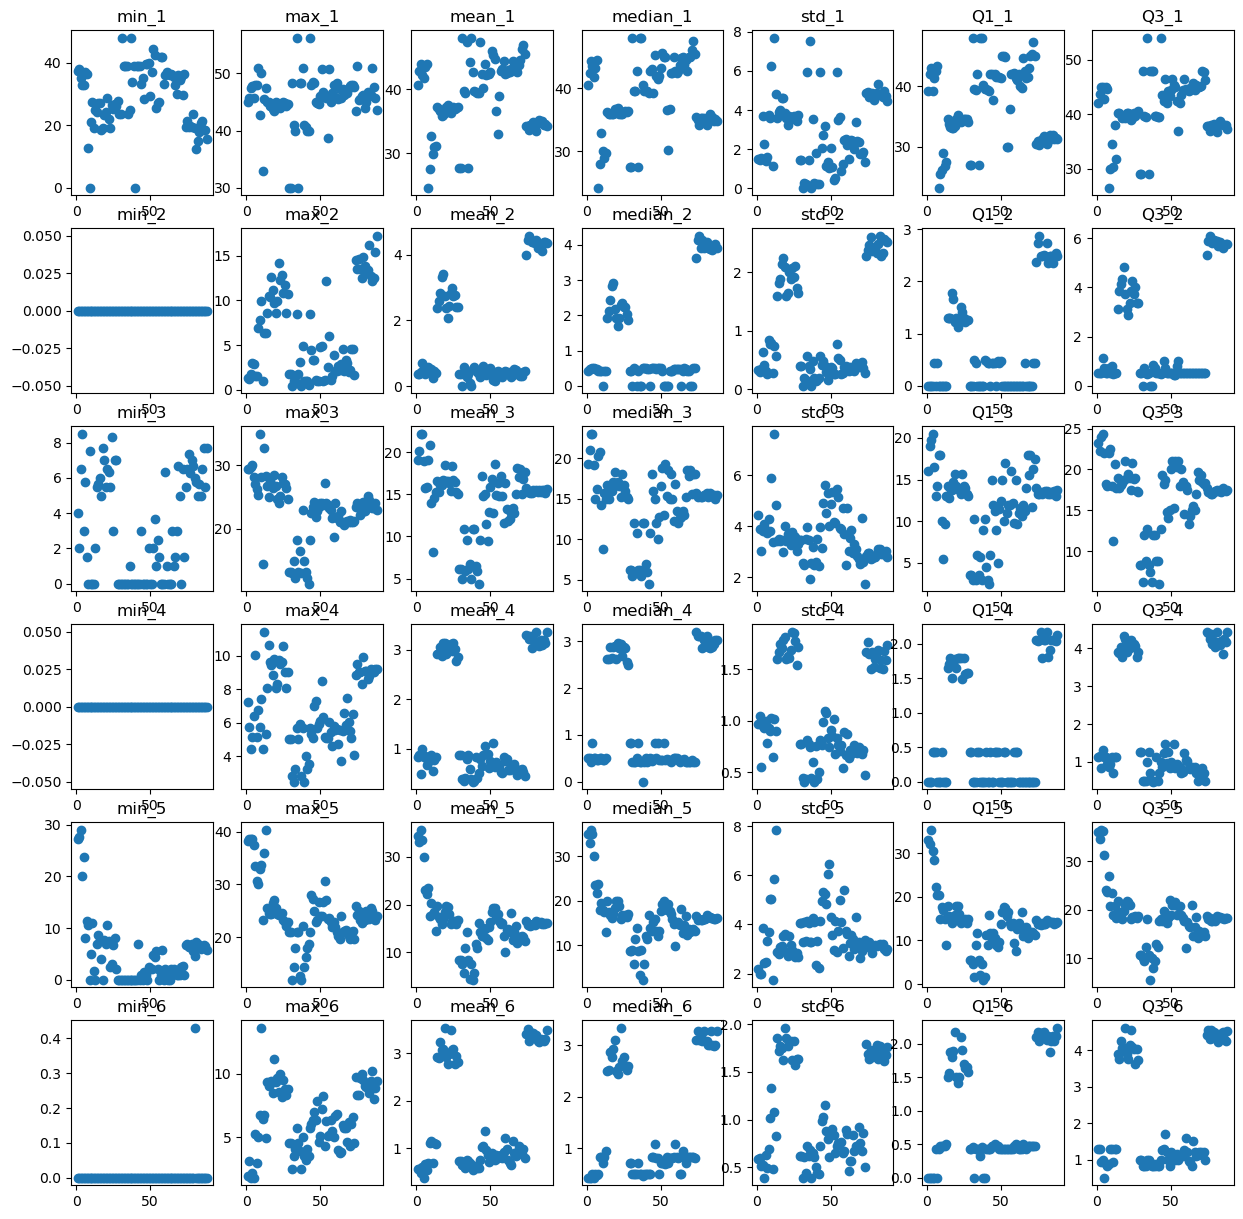

In [9]:
sns.set_context({'figure.figsize':[15, 15]})
for i in range(len(col_rename)):
    plt.subplot(6,7,i+1)
    plt.scatter(list(range(1,89)),list(features[col_rename[i]]))
    plt.title(col_rename[i])
plt.show()

    According to summary table above(focus on ranges and estimated standard deviations, I prefer to choose min value, max value and median value. Although the mins are always 0 for some time series, it still seems meaningful. Almost all features distribute well, and in terms of correlation between features, mean will be affected by max and min value, so I prefer median which will not be affcted. So I think min, max and median are fine.
    

### 2. ISLR 3.7.4
I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X2 +β3X3 +ε.

### 2.a
Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. 

Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

    I think the cubic regression will have a lower training RSS. Because it could make a tighter and closer fit against data. 

### 2.b
Answer (a) using test rather than training RSS.

    When talking about test RSS I think the cubic regression will have a higher test RSS since the tighter fit in training may cause overfit and that will lead to more error.

### 2.c
Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. 

Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.


    I think cubic regression will have lower training RSS than the linear fit because of its higher flexibility which could fit the data closer no matter what the real relationship is.

### 2.d
Answer (c) using test rather than training RSS.

    I think it depends on how far the real relationship from linear. If it is closer to linear than cubic, the test RSS of linear regression will be lower than that of cubic regression. If it is closer to cubic then the test RSS of cubic regression will be lower.
    
    So since there is no enough information, I can't tell which one will be lower. 